# Penguin Random House Dataset

The data were collected in January 2022 from [Penguin Random House](https://www.penguinrandomhouse.com/) via [API](https://developer.penguinrandomhouse.com/page).

The collected data were parsed and saved [in this folder](data_interm) (see details [here](downloading.ipynb)).

In [1]:
import os
import sys

# Append sys.path with the project root path
sys.path.append(os.path.dirname(os.path.abspath('')))

In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
from bs4 import BeautifulSoup
from treelib import Tree

from utils.preprocessing import get_weighted_rating

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

# To print many rows
pd.set_option('display.max_rows', 100)

# To wrap long values
pd.set_option('display.max_colwidth', 78)

# To use seaborn style for plots
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_context('talk')
sns_palette = sns.color_palette(plt.cm.get_cmap('tab20c').colors)

## Categories

Books are assigned to one or more categories identified by a numeric `cat_id`. Each category is part of a larger category set and may be arranged in relation to other categories in the set to form a hierarchy.

In [3]:
# Load categories info
path_cats = os.path.join('data_interm', 'categories.txt')

# Read data
categories = pd.read_json(path_cats, lines=True)

# Set the proper types
categories['parent'] = categories['parent'].astype('Int64')
categories['cat_id'] = categories['cat_id'].astype('Int64')

# Set index
categories.set_index('cat_id', inplace=True)

# Change the name of the top category
categories.loc[2000000000, 'menu_text'] = 'Consumer Category'

# Show
categories.head(10)

,description,menu_text,parent
cat_id,,,
2000000000,Consumer Category,Consumer Category,<NA>
2000000029,Children's Books,Children's,2000000000
2000000006,Children's Activity & Novelty Books,Activity & Novelty Books,2000000029
2000000022,Children's Board Books,Board Books,2000000029
2000000023,Children's Boxed Sets,Boxed Sets,2000000029
2000000028,Children's Chapter Books,Chapter Books,2000000029
2000000100,Children's Middle Grade Books,Middle Grade Books,2000000029
2000000005,Children's Middle Grade Action & Adventure Books,Action & Adventure,2000000100
2000000055,Children's Middle Grade Fantasy & Magical Books,Fantasy,2000000100


Each category has the following [properties](https://developer.penguinrandomhouse.com/docs/read/enhanced_prh_api/concepts/Categories):
- `cat_id`, a number that uniquely identifies this category
- `menu_text`, a brief description of the category, suitable for use in a navigational menu
- `description`, the description of the category, suitable for display
- `parent`, it is a `cat_id` of the parent category

In [4]:
# If there are NaNs
mask = categories.isna().any(axis=1)
categories[mask]

# This is ok, because the highest level doesn't have a parent

,description,menu_text,parent
cat_id,,,
2000000000,Consumer Category,Consumer Category,<NA>


In [5]:
# Visualize the hierarchy
tree = Tree()
for index, row in categories.iterrows():

    # If this category is the top
    if pd.isna(row.parent):
        tree.create_node(row.menu_text, index)
        continue

    # Child categories
    tree.create_node(row.menu_text, index, parent=row.parent)

tree.show()

Consumer Category
├── Audiobooks
├── Children's
│   ├── Activity & Novelty Books
│   ├── Board Books
│   ├── Boxed Sets
│   ├── Chapter Books
│   ├── Guided Reading Levels
│   │   ├── Leveled Readers
│   │   │   ├── Level 1 Readers
│   │   │   ├── Level 2 Readers
│   │   │   ├── Level 3 Readers
│   │   │   └── Level 4 Readers
│   │   └── Step Into Reading 
│   ├── Media Tie-In
│   ├── Middle Grade Books
│   │   ├── Action & Adventure
│   │   ├── Fantasy
│   │   ├── Historical
│   │   ├── Mystery & Detective
│   │   └── Sports
│   ├── Picture Books
│   ├── Spanish Language 
│   └── Test Preparation
├── Classics
│   ├── Fiction Classics
│   ├── Literary Collections
│   ├── Literary Criticism
│   └── Nonfiction Classics
├── Fiction
│   ├── Gothic & Horror
│   ├── Graphic Novels & Manga
│   ├── Historical 
│   ├── Literary
│   ├── Military 
│   ├── Mystery & Suspense
│   │   ├── Cozy 
│   │   ├── Crime
│   │   ├── Espionage
│   │   ├── Noir
│   │   └── Suspense & Thriller
│   ├── Paranorma

## Contributor Roles

In PRH, every ISBN has up to five people mapped to it and each mapping is qualified with a contributor role code that identifies the type of contribution that person made to the ISBN.

Beside of the role code and description, there is a sequence value that [is used](https://developer.penguinrandomhouse.com/docs/read/enhanced_prh_api/concepts/Contributor_role) to prioritize certain roles over others. This sequencing is used to order contributors within a work or ISBN.

In [6]:
# Load roles
path_roles = os.path.join('data_interm', 'contributor_roles.txt')
roles = pd.read_json(path_roles, lines=True)

# Rename code to `role_id`
roles.rename(columns={'code': 'role_id'}, inplace=True)
roles.set_index('role_id', inplace=True)
roles.head(10)

,description,seq
role_id,,
A,Author,10
I,Illustrator,20
4,Read by,30
U,Foreword by,40
V,Introduction by,50
1,Preface by,60
E,Editor,70
D,Afterword by,80
Q,Epilogue by,90


## Books

In [7]:
# Load books info
path_books = os.path.join('data_interm', 'books.txt')
books = pd.read_json(path_books, lines=True)

# Set `isbn` column as index
books.set_index('isbn', inplace=True)
books.head(2)

,title,onsale,price,language,pages,publisher,cover,format_family,projected_minutes,series_number,authors,categories,series,works,flapcopy,excerpt
isbn,,,,,,,,,,,,,,,,
9780375760686,Morningside Heights,2005-07-12,"[{'amount': 21.0, 'currencyCode': 'CAD', 'pricingType': None}, {'amount': ...",E,352.0,"{'code': '7070', 'description': 'Random House Publishing Group'}",https://images.randomhouse.com/cover/9780375760686,Paperback,NaN,NaN,"[{'author_id': 35922, 'first_name': 'Cheryl', 'last_name': 'Mendelson', 'c...","[{'category_id': 2000000083, 'seq': 1}, {'category_id': 3000001343, 'seq':...",[],"[{'work_id': 113275, 'title': 'Morningside Heights', 'author': 'Cheryl Men...","Following the tremendous success of her first book, a nonfiction work on h...",<b>1</b><br><br>This neighborhood was always middle-class and urban. The a...
9781605295336,Going Long,2010-03-30,"[{'amount': 16.99, 'currencyCode': 'USD', 'pricingType': None}, {'amount':...",E,400.0,"{'code': '5H5H', 'description': 'Harmony/Rodale'}",https://images.randomhouse.com/cover/9781605295336,Paperback,NaN,NaN,"[{'author_id': 2061538, 'first_name': 'David', 'last_name': 'Willey', 'com...","[{'category_id': 2000000052, 'seq': 3}, {'category_id': 2000000144, 'seq':...","[{'series_id': 'D22', 'name': 'Runner's World', 'description': None, 'seri...","[{'work_id': 594144, 'title': 'Going Long', 'author': 'Edited by David Wil...","For more than 40 years, <i>Runner's World </i>magazine has been the world'...",None


In [8]:
books.dtypes

title                 object
onsale                object
price                 object
language              object
pages                float64
publisher             object
cover                 object
format_family         object
projected_minutes    float64
series_number        float64
authors               object
categories            object
series                object
works                 object
flapcopy              object
excerpt               object
dtype: object

Let's analyze each column individually.

### Onsale

Values of the column `onsale` are dates when books began to be sold. So, convert them to the appropriate type:

In [9]:
# If there are NaNs
books['onsale'].isna().any()

False

In [10]:
# Convert to datetime
books['onsale'] = pd.to_datetime(books['onsale'])

# Rename
books.rename(columns={'onsale': 'onsale_date'}, inplace=True)

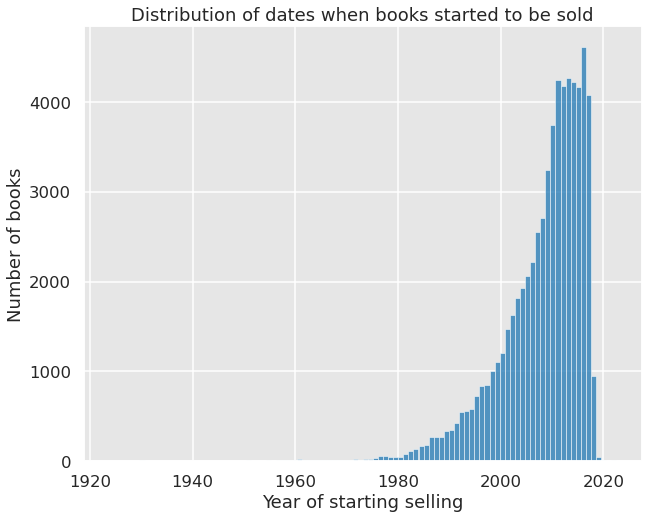

In [11]:
# Show the distribution
_, ax = plt.subplots(figsize=(10, 8))
sns.histplot(x=books['onsale_date'],
             palette=sns_palette, ax=ax, bins=100)
ax.set_ylabel('Number of books')
ax.set_xlabel('Year of starting selling')
ax.set_title('Distribution of dates when books started to be sold')
plt.show()

In [12]:
# Show the newest and the oldest books
books_sorted_onsale = books.sort_values('onsale_date')

# The oldest books
books_sorted_onsale[['title', 'onsale_date']].head(5)

,title,onsale_date
isbn,,
9780394404288,The Prophet,1923-09-12
9780448089010,Hardy Boys 01: the Tower Treasure,1927-06-01
9780448089027,Hardy Boys 02: the House on the Cliff,1927-06-01
9780448089034,Hardy Boys 03: the Secret of the Old Mill,1927-06-01
9780448089058,Hardy Boys 05: Hunting for Hidden Gold,1928-05-01


In [13]:
# The newest (their selling will start soon)
books_sorted_onsale[['title', 'onsale_date']].tail(5)

,title,onsale_date
isbn,,
9788499083209,Trilogía de la Fundación / The Foundation Trilogy,2022-03-22
9788415594765,Wonder: Charlotte tiene la palabra / Shingaling. A Wonder Story,2022-04-05
9780553539233,Super-Pets! (DC Super Friends),2022-04-05
9780451419903,Mark of the Hunter,2022-04-26
9780375806131,The Name Jar,2022-07-19


### Language

The column `language` contains book languages.

In [14]:
# There are books in different languages:
books['language'].value_counts(dropna=False)

E     64232
SP      691
FR        2
JA        1
CH        1
IT        1
LA        1
Name: language, dtype: int64

The majority of books, of course, in English. Convert the language codes to their full names:

In [15]:
languages = {
    'E': 'English',
    'SP': 'Spanish',
    'FR': 'French',
    'JA': 'Japanese',
    'CH': 'Chinese',
    'IT': 'Italian',
    'LA': 'Latin',
}

books['language'].replace(languages, inplace=True)

### Cover

These values are just images of book covers:

In [16]:
# Look at a random image
Image(url=books.loc[9780375806131, 'cover'])

### Title

Book titles. Check if there are missing titles:

In [17]:
books['title'].isna().any()

False

### Price

The dataset contains `price` information in different currencies:

In [18]:
books['price'].head(5)

isbn
9780375760686    [{'amount': 21.0, 'currencyCode': 'CAD', 'pricingType': None}, {'amount': ...
9781605295336    [{'amount': 16.99, 'currencyCode': 'USD', 'pricingType': None}, {'amount':...
9780771095764    [{'amount': 19.99, 'currencyCode': 'CAD', 'pricingType': None}, {'amount':...
9780679751403    [{'amount': 17.95, 'currencyCode': 'CAD', 'pricingType': None}, {'amount':...
9780812974874    [{'amount': 18.0, 'currencyCode': 'USD', 'pricingType': None}, {'amount': ...
Name: price, dtype: object

In [19]:
book_price = books[['price']].explode('price')

However, there are some text NaNs:

In [20]:
book_price['price'].isna().any()

True

In [21]:
# Drop nans and convert from dict to data frame
book_price = book_price.dropna().reset_index()
book_price = book_price.drop('price', axis=1)\
    .join(pd.DataFrame(book_price['price'].tolist()))
book_price.head(10)

,isbn,amount,currencyCode,pricingType
0,9780375760686,21.00,CAD,None
1,9780375760686,16.00,USD,None
2,9781605295336,16.99,USD,None
3,9781605295336,19.99,CAD,None
4,9780771095764,19.99,CAD,None
5,9780771095764,17.95,USD,None
6,9780679751403,17.95,CAD,None
7,9780679751403,15.95,USD,None
8,9780812974874,18.00,USD,None
9,9780812974874,24.00,CAD,None


In [22]:
# Empty column
book_price['pricingType'].isna().all()

True

In [23]:
# Get pivot table with prices in different currencies
book_price = book_price.pivot(index='isbn', columns='currencyCode',
                              values='amount')
book_price.head(5)

currencyCode,CAD,USD
isbn,,
9780131872783,23.0,17.0
9780132157575,73.0,55.0
9780133036039,21.0,20.0
9780133102109,29.0,25.0
9780135853986,23.0,17.0


In [24]:
# All USD values are present
book_price['USD'].isna().any()

False

In [25]:
# Join prices with the main dataset
# Keep only USD
books = books.join(book_price[['USD']])

# Drop the old column with price
books.drop(columns=['price'], inplace=True)

# Rename USD to price 
books.rename(columns={'USD': 'price'}, inplace=True)

In [26]:
# Show the distribution of the prices
books['price'].describe()

count    64920.000000
mean        15.293190
std          8.766339
min          0.990000
25%          8.990000
50%         15.000000
75%         18.000000
max        429.790000
Name: price, dtype: float64

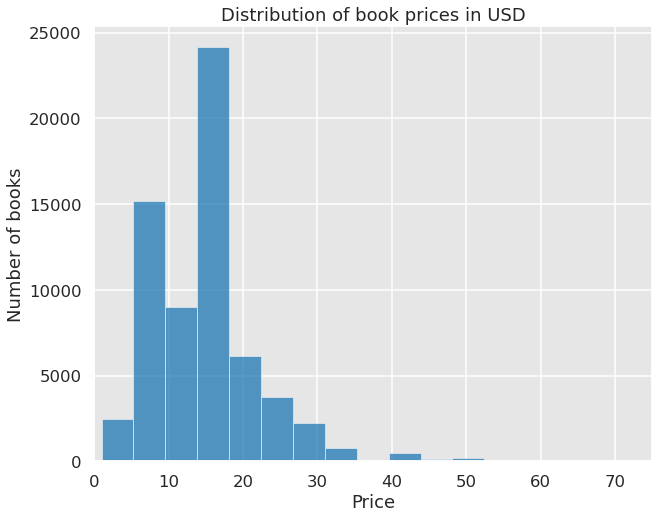

In [27]:
# Show the distribution of the prices
_, ax = plt.subplots(figsize=(10, 8))
sns.histplot(x=books['price'], bins=100,
             palette=sns_palette, ax=ax)
ax.set_xlim(0, 75)
ax.set_ylabel('Number of books')
ax.set_xlabel('Price')
ax.set_title('Distribution of book prices in USD')
plt.show()

In [28]:
# Show the most expensive books
books_price_sorted = books.sort_values(['price'], ascending=False)
books_price_sorted[['title', 'price']].head(10)

,title,price
isbn,,
9780739352243,Harry Potter 1-7 Audio Collection,429.79
9780739352960,George R. R. Martin Song of Ice and Fire Audiobook Bundle,340.00
9780385537933,Sycamore Row - Limited Edition,250.00
9780385510448,The Last Juror (Limited Edition),250.00
9780385503839,The Summons (Limited Edition),250.00
9780385351478,Robert A. Caro's The Years of Lyndon Johnson Set,224.95
9780307700766,"The Decline and Fall of the Roman Empire, Volumes 1 to 6",180.00
9780723257639,The Original Peter Rabbit Presentation Box 1-23 R/I,170.00
9781401234591,The Invisibles Omnibus,150.00


### Format

Here, there are several book formats:

In [29]:
books['format_family'].value_counts(dropna=False)

Paperback      41043
Ebook          10501
Hardcover       9645
Audio           2854
Board Book       653
Merchandise      122
Boxed Set        111
Name: format_family, dtype: int64

They are already well written. There is nothing to improve here, just to rename:

In [30]:
books.rename(columns={'format_family': 'format'}, inplace=True)

### Pages and Minutes

There are two columns considering length of book: pages and projected_minutes (for audiobooks):

In [31]:
books[['pages', 'projected_minutes', 'format']].head()

,pages,projected_minutes,format
isbn,,,
9780375760686,352.0,NaN,Paperback
9781605295336,400.0,NaN,Paperback
9780771095764,336.0,NaN,Paperback
9780679751403,224.0,NaN,Paperback
9780812974874,320.0,NaN,Paperback


In [32]:
audio_mask = books['format'] == 'Audio'
audio_books = books.loc[audio_mask, ['title', 'pages', 'projected_minutes']]
nonaudio_books = books.loc[~audio_mask, ['title', 'pages', 'projected_minutes']]

In [33]:
# There are NaNs
audio_books['projected_minutes'].isna().any()

True

In [34]:
# There are NaNs
nonaudio_books['pages'].isna().any()

True

In [35]:
# Prove that audiobooks have no pages
audio_books['pages'].isna().all()

True

In [36]:
# Prove that non-audio books have no minutes
nonaudio_books['projected_minutes'].isna().all()

True

In [37]:
# Show the longest non-audio books
nonaudio_books.sort_values('pages', ascending=False).head(10)

,title,pages,projected_minutes
isbn,,,
9780345544742,The Complete Vampire Chronicles 12-Book Bundle,5392.0,NaN
9781101965481,George R. R. Martin's A Game of Thrones Leather-Cloth Boxed Set (Song of I...,5280.0,NaN
9780345535535,George R. R. Martin's A Game of Thrones 5-Book Boxed Set (Song of Ice and ...,5216.0,NaN
9780141398877,Little Black Classics Box Set,5120.0,NaN
9780345546005,The Earth's Children Series 6-Book Bundle,4528.0,NaN
9780307700766,"The Decline and Fall of the Roman Empire, Volumes 1 to 6",3980.0,NaN
9780804180740,The Will Trent Series 7-Book Bundle,3824.0,NaN
9780141198415,Major Works of Charles Dickens (Penguin Classics hardcover boxed set),3488.0,NaN
9780307930675,The Inheritance Cycle 4-Book Hard Cover Boxed Set,2912.0,NaN


In [38]:
# Show the longest audiobooks
audio_books.sort_values('projected_minutes', ascending=False).head(10)

,title,pages,projected_minutes
isbn,,,
9780307914187,The Power Broker,NaN,3967.0
9780739375976,A Dance with Dragons,NaN,2940.0
9780739375983,A Dance with Dragons,NaN,2935.0
9780739308738,A Storm of Swords,NaN,2854.0
9780449011904,A Storm of Swords,NaN,2850.0
9780804164818,Tune In,NaN,2625.0
9781101436875,Washington,NaN,2510.0
9781415936245,The Autobiography of Henry VIII,NaN,2478.0
9780307576606,Defend the Realm,NaN,2378.0


### Flapcopy and Excerpt

There are several columns with text description:

- `flapcopy`, the brief summary that often appears on the inside of a hardcover book's dust jacket.
- `excerpt`, a fragment from the book.

In [39]:
books[['flapcopy', 'excerpt']].head(5)

,flapcopy,excerpt
isbn,,
9780375760686,"Following the tremendous success of her first book, a nonfiction work on h...",<b>1</b><br><br>This neighborhood was always middle-class and urban. The a...
9781605295336,"For more than 40 years, <i>Runner's World </i>magazine has been the world'...",None
9780771095764,<b>Named NOW Magazine&rsquo;s Best Emerging Local Author <br><br><br>Where...,"<b>Excerpt from Chapter 3:<br></b><br>Wednesday after school, Mom and I to..."
9780679751403,"In an astonishing feat of literary detection, one of the most provocative ...",None
9780812974874,<b><i>New Yorker </i>writer and author of <i>The Library Book</i> takes re...,"Lifelike<br><br> As soon as the 2003 World Taxidermy Championships opened,..."


The values contain a lot of HTML tags. Let's remove them:

In [40]:
def clean_text(text: str) -> str:
    """Clean text from HTML tags."""
    return BeautifulSoup(text, 'lxml').getText()\
        .replace(u'\xa0', ' ').strip()


for col in ['flapcopy', 'excerpt']:
    nans = books[col].isna()
    books.loc[~nans, col] = books.loc[~nans, col].apply(clean_text)

In [41]:
# Show how many descriptions are absent
for col in ['flapcopy', 'excerpt']:
    nans_count = books[col].isna().sum()
    print(f'{round(100 * nans_count / len(books))}% of column {col} are absent.')

0% of column flapcopy are absent.
56% of column excerpt are absent.


### Publisher

The column contains book publishers.

In [42]:
books['publisher'].head(5)

isbn
9780375760686       {'code': '7070', 'description': 'Random House Publishing Group'}
9781605295336                      {'code': '5H5H', 'description': 'Harmony/Rodale'}
9780771095764                {'code': '4747', 'description': 'McClelland & Stewart'}
9780679751403    {'code': '7373', 'description': 'Knopf Doubleday Publishing Group'}
9780812974874       {'code': '7070', 'description': 'Random House Publishing Group'}
Name: publisher, dtype: object

In [43]:
# Parse dicts
book_publisher = books[['publisher']].dropna().reset_index()
book_publisher = book_publisher.drop('publisher', axis=1)\
    .join(pd.DataFrame(book_publisher['publisher'].tolist()))
book_publisher.set_index('isbn', inplace=True)
book_publisher.head(5)

,code,description
isbn,,
9780375760686,7070,Random House Publishing Group
9781605295336,5H5H,Harmony/Rodale
9780771095764,4747,McClelland & Stewart
9780679751403,7373,Knopf Doubleday Publishing Group
9780812974874,7070,Random House Publishing Group


In [44]:
# If there are any NaNs
book_publisher.isna().any()

code           False
description    False
dtype: bool

In [45]:
# The most frequent publishers
book_publisher['description'].value_counts().head(10)

Penguin Publishing Group                       16007
Random House Publishing Group                  10563
Knopf Doubleday Publishing Group                6970
Penguin Young Readers Group                     3860
Random House Children's Books                   3676
Penguin Random House Audio Publishing Group     2826
Crown                                           1810
Candlewick Press                                1526
Clarkson Potter/Ten Speed                       1177
The Crown Publishing Group                      1060
Name: description, dtype: int64

In [46]:
# Join parsed publishers with the main dataframe
# Keep only publisher's code
books = books.join(book_publisher[['code']])

# Drop the old column with publishers
books.drop(columns=['publisher'], inplace=True)

# Rename publisher code to publisher_id 
books.rename(columns={'code': 'publisher_id'}, inplace=True)

In [47]:
# Move publisher data to a separate dataframe
publishers = book_publisher.drop_duplicates('code')\
    .rename(columns={'code': 'publisher_id', 'description': 'name'})\
    .set_index('publisher_id')
publishers.head(5)

,name
publisher_id,
7070,Random House Publishing Group
5H5H,Harmony/Rodale
4747,McClelland & Stewart
7373,Knopf Doubleday Publishing Group
6262,Penguin Publishing Group


### Series

Let's extract the series information. Each row contains a `series_number` and info about `series` itself.

In [48]:
# Most of the books are not in any series
no_series = books['series_number'].isna().sum()
print(f'{no_series} of {len(books)} books are not part of any series.')

# Convert series_number to int data type
books['series_number'] = books['series_number'].astype('Int32')

48726 of 64929 books are not part of any series.


In [49]:
books[['series', 'series_number']].head(5)

,series,series_number
isbn,,
9780375760686,[],<NA>
9781605295336,"[{'series_id': 'D22', 'name': 'Runner's World', 'description': None, 'seri...",<NA>
9780771095764,[],<NA>
9780679751403,[],<NA>
9780812974874,[],<NA>


In [50]:
# Move information about series in a separate dataframe
book_series = books[['series']].explode('series').dropna().reset_index()
book_series = book_series.drop('series', axis=1)\
    .join(pd.DataFrame(book_series['series'].tolist()))
book_series.set_index('isbn', inplace=True)
book_series.head(5)

,series_id,name,description,series_count,is_numbered,is_kids
isbn,,,,,,
9781605295336,D22,Runner's World,None,37,False,False
9781601427762,DXR,Double S Ranch,"Come Home to the Double S Ranch...<br>Where the Cowboys are Loving, Strong...",3,True,False
9781601427809,DXR,Double S Ranch,"Come Home to the Double S Ranch...<br>Where the Cowboys are Loving, Strong...",3,True,False
9780451467935,BVP,Sugarland Blue Novel,The sexy officers of the Sugarland Police Department struggle to keep both...,6,True,False
9780451476999,BVP,Sugarland Blue Novel,The sexy officers of the Sugarland Police Department struggle to keep both...,6,True,False


In [51]:
# Drop HTML tags from description
description_nans = book_series['description'].isna()
book_series.loc[~description_nans, 'description'] = \
    book_series.loc[~description_nans, 'description'].apply(clean_text)

In [52]:
# Save only `series_id` in the main dataset
books = books.join(book_series[['series_id']])

# Drop series column
books.drop(columns=['series'], inplace=True)

# Rename
books.rename(columns={'series_number': 'number_in_series'}, inplace=True)

In [53]:
# Move series data to a separate dataframe
series = book_series.drop_duplicates('series_id').set_index('series_id')

series.head(5)

,name,description,series_count,is_numbered,is_kids
series_id,,,,,
D22,Runner's World,None,37,False,False
DXR,Double S Ranch,"Come Home to the Double S Ranch...Where the Cowboys are Loving, Strong, an...",3,True,False
BVP,Sugarland Blue Novel,The sexy officers of the Sugarland Police Department struggle to keep both...,6,True,False
NSW,Star Wars,None,6,True,False
NYC,NYRB Classics,None,31,False,False


In [54]:
# How many unique series exists
len(series)

4743

In [55]:
# Show series with the largest number of books
series.sort_values('series_count', ascending=False).head(10)

,name,description,series_count,is_numbered,is_kids
series_id,,,,,
VCO,Vintage Contemporaries,Vintage Contemporaries offers readers stylish trade paperback editions of ...,694,False,False
LGB,Little Golden Book,LITTLE GOLDEN BOOKS have been loved by children for over 75 years. When th...,681,False,True
PBK,Pictureback(R),None,273,False,True
GNO,Good Night Our World,The Good Night Books series is designed to celebrate special places and su...,213,False,True
DWY,Who Was?,A series of illustrated biographies for young readers featuring significan...,210,False,True
BFV,Longarm,None,185,True,False
BT5,Slocum,"The longest-running Western series in America today, the Slocum adventures...",176,True,False
VTS,A Vintage Short,The Vintage Shorts series presents timely reading from enduring classics a...,176,False,False
ADI,Travel Guide,"For more than two decades, DK Eyewitness Travel Guides have helped travele...",172,False,False


### Contributors

The column `authors` may contain illustrators, photographer in addition to the main author.

In [56]:
books['authors'].head(5)

isbn
9780375760686    [{'author_id': 35922, 'first_name': 'Cheryl', 'last_name': 'Mendelson', 'c...
9781605295336    [{'author_id': 2061538, 'first_name': 'David', 'last_name': 'Willey', 'com...
9780771095764    [{'author_id': 83047, 'first_name': 'Lauren', 'last_name': 'Kirshner', 'co...
9780679751403    [{'author_id': 18770, 'first_name': 'Janet', 'last_name': 'Malcolm', 'comp...
9780812974874    [{'author_id': 22849, 'first_name': 'Susan', 'last_name': 'Orlean', 'compa...
Name: authors, dtype: object

In [57]:
# Move information about authors in a separate dataframe
book_authors = books[['authors']].explode('authors').dropna().reset_index()
book_authors = book_authors.drop('authors', axis=1)\
    .join(pd.DataFrame(book_authors['authors'].tolist()))
book_authors.set_index('isbn', inplace=True)
book_authors.head(5)

,author_id,first_name,last_name,company,client_source_id,role
isbn,,,,,,
9780375760686,35922,Cheryl,Mendelson,"{'key': 'R_H', 'value': None}",0,A
9781605295336,2061538,David,Willey,"{'key': 'R_H', 'value': None}",0,E
9781605295336,2213465,None,Editors of Runner's World Maga,"{'key': 'R_H', 'value': None}",0,E
9780771095764,83047,Lauren,Kirshner,"{'key': 'R_H', 'value': None}",0,A
9780679751403,18770,Janet,Malcolm,"{'key': 'R_H', 'value': None}",0,A


Since a book may have several authors, we need a dataframe for mapping book-authors and another one for author information.

In [58]:
# Dataframe for authors info
authors = book_authors[['author_id', 'first_name', 'last_name', 
                        'company', 'client_source_id']]\
    .drop_duplicates('author_id').set_index('author_id')
authors.head(5)

,first_name,last_name,company,client_source_id
author_id,,,,
35922,Cheryl,Mendelson,"{'key': 'R_H', 'value': None}",0
2061538,David,Willey,"{'key': 'R_H', 'value': None}",0
2213465,None,Editors of Runner's World Maga,"{'key': 'R_H', 'value': None}",0
83047,Lauren,Kirshner,"{'key': 'R_H', 'value': None}",0
18770,Janet,Malcolm,"{'key': 'R_H', 'value': None}",0


In [59]:
# Dataframe for mapping books and authors
book_authors = book_authors[['author_id', 'role']].reset_index()
book_authors.rename(columns={'role': 'role_id'}, inplace=True)
book_authors.head(5)

,isbn,author_id,role_id
0,9780375760686,35922,A
1,9781605295336,2061538,E
2,9781605295336,2213465,E
3,9780771095764,83047,A
4,9780679751403,18770,A


In [60]:
# Drop authors from books
books.drop(columns='authors', inplace=True)

In some cases, we can see the same information about authors with different ids. For example:

In [61]:
authors.loc[[159086, 20334]]

,first_name,last_name,company,client_source_id
author_id,,,,
159086,Daniel,Mendelsohn,"{'key': 'DL', 'value': 'New York Review Books'}",20334
20334,Daniel,Mendelsohn,"{'key': 'R_H', 'value': None}",0


Here is the rephrased explanation from [the PRH site](https://developer.penguinrandomhouse.com/docs/read/enhanced_prh_api/concepts/Multiple_authors):
In cases where an author contributes to books by both a core PRH division and by one of our distribution clients, MyHouse (content management system) creates a separate author ID so that our distribution clients have the opportunity to attach their own content to that ID. This is why there are two 
author records in our system.

In this way, distribution authors, whose IDs were created within the content management system as copies of core authors, have `client_source_id` as a reference to the `author_id` of the core author. We can see from the values on the 159086 Daniel Mendelsohn record that it has a reference to the 20334 record.

Here, we can assume that the persons themselves are more important than the company where they work. So, we can use only one ID per author and skip the company info.

In [62]:
external_authors = authors[authors['client_source_id'] > 0]
rh_authors = authors[authors['client_source_id'] == 0]

In [63]:
works_rh = external_authors['client_source_id'].isin(rh_authors.index)

# If author works in RH, change to the main `source_id`
rh_converted = external_authors.loc[works_rh, 'client_source_id'].to_dict()
authors.rename(index=rh_converted, inplace=True)
book_authors['author_id'].replace(rh_converted, inplace=True)

# If author does not work in RH, set `client_source_id` as main
nrh_converted = external_authors.loc[~works_rh, 'client_source_id'].to_dict()
authors.rename(index=nrh_converted, inplace=True)
book_authors['author_id'].replace(nrh_converted, inplace=True)

# Drop duplicates and unused columns
authors.drop(columns=['client_source_id', 'company'], inplace=True)
authors = authors[~authors.index.duplicated(keep='first')]

# Show
authors.head()

,first_name,last_name
author_id,,
35922,Cheryl,Mendelson
2061538,David,Willey
2213465,None,Editors of Runner's World Maga
83047,Lauren,Kirshner
18770,Janet,Malcolm


### Works

Here is the explanation of work from the PRH: Work ID is a Penguin Random House internally managed number that serves to group different formats of a title together. The object identified by the work ID is called the Work, and it represents the collection of all the different ISBNs together as a single object. Even though a Work is just a collection of ISBNs and does not have data of its own, certain attributes are computed at load time based on rules derived from the available ISBNs. The onsale date attribute is taken from the ISBN in the work with the oldest on-sale date. The title, subtitle and author (the display field) are derived a little differently. For each field, the ISBN values are sorted alphabetically and the first value is used as the work attribute. All other data is derived for a Work based on the ISBNs it has (more details [here](https://developer.penguinrandomhouse.com/docs/read/enhanced_prh_api/concepts/Works_and_ISBNs)).

In [64]:
books['works'].head(5)

isbn
9780375760686    [{'work_id': 113275, 'title': 'Morningside Heights', 'author': 'Cheryl Men...
9781605295336    [{'work_id': 594144, 'title': 'Going Long', 'author': 'Edited by David Wil...
9780771095764    [{'work_id': 93322, 'title': 'Where We Have to Go', 'author': 'Lauren Kirs...
9780679751403    [{'work_id': 106482, 'title': 'The Silent Woman', 'author': 'Janet Malcolm...
9780812974874    [{'work_id': 124840, 'title': 'My Kind of Place', 'author': 'Susan Orlean'...
Name: works, dtype: object

In [65]:
# Parse dicts
book_work = books[['works']].explode('works').dropna().reset_index()
book_work = book_work.drop('works', axis=1)\
    .join(pd.DataFrame(book_work['works'].tolist()))
book_work.set_index('isbn', inplace=True)
book_work.head(5)

,work_id,title,author,onsale,language,series_number
isbn,,,,,,
9780375760686,113275,Morningside Heights,Cheryl Mendelson,2005-07-12,E,None
9781605295336,594144,Going Long,Edited by David Willey,2010-03-30,E,None
9780771095764,93322,Where We Have to Go,Lauren Kirshner,2012-03-06,E,None
9780679751403,106482,The Silent Woman,Janet Malcolm,1995-03-28,E,None
9780812974874,124840,My Kind of Place,Susan Orlean,2005-10-11,E,None


In [66]:
# Each book have only one `work_id`
book_work.index.duplicated().any()

False

In [67]:
# Save only `work_id` in the main dataset
books = books.join(book_work[['work_id']])

# Drop works column
books.drop(columns=['works'], inplace=True)

To avoid the duplication between book data and work data, we can find and save only one isbn per work that will present its information. Let's use the same steps to find the front ISBN as it is written in the description from PRH.

In [68]:
# Use only `work_id`
works = book_work.loc[:, ['work_id']]
works.reset_index(inplace=True)

# Determine front ISBN
works.sort_values('isbn', inplace=True)
works.drop_duplicates('work_id', keep='first', inplace=True)
works.set_index('work_id', inplace=True)
works.rename(columns={'isbn': 'front_isbn'}, inplace=True)

# Show
works.head(5)

,front_isbn
work_id,
299263,9780131872783
352442,9780132157575
350692,9780133036039
353576,9780133102109
304057,9780135853986


### Categories

Categories are sequenced such that the first category should be considered more relevant or important than the last. 

In [69]:
books['categories'].head(5)

isbn
9780375760686    [{'category_id': 2000000083, 'seq': 1}, {'category_id': 3000001343, 'seq':...
9781605295336    [{'category_id': 2000000052, 'seq': 3}, {'category_id': 2000000144, 'seq':...
9780771095764    [{'category_id': 2000000083, 'seq': 1}, {'category_id': 3000001343, 'seq':...
9780679751403    [{'category_id': 2000000013, 'seq': 1}, {'category_id': 2000000082, 'seq':...
9780812974874    [{'category_id': 2000000021, 'seq': 2}, {'category_id': 2000000154, 'seq':...
Name: categories, dtype: object

In [70]:
# Move information about categories in a separate dataframe
book_cats = books[['categories']].explode('categories').dropna().reset_index()
book_cats = book_cats.drop('categories', axis=1)\
    .join(pd.DataFrame(book_cats['categories'].tolist()))
book_cats.head(5)

,isbn,category_id,seq
0,9780375760686,2000000083,1
1,9780375760686,3000001343,3
2,9780375760686,3000001361,2
3,9780375760686,3000001404,1
4,9781605295336,2000000052,3


In [71]:
# Drop category column from the main dataset
books.drop(columns='categories', inplace=True)

There are a lot of category sets [in the PRH](https://developer.penguinrandomhouse.com/docs/read/enhanced_prh_api/concepts/Categories). However, we use only "CN" categories here. Thus, we need to remove unnecessary ones.

In [72]:
book_cats = book_cats[book_cats['category_id'].isin(categories.index)]
book_cats.head(5)

,isbn,category_id,seq
0,9780375760686,2000000083,1
4,9781605295336,2000000052,3
5,9781605295336,2000000144,1
9,9780771095764,2000000083,1
13,9780679751403,2000000013,1


## Ratings

In [73]:
# Load all ratings
path_ratings = os.path.join('data_interm', 'ratings_joined.csv')
ratings = pd.read_csv(path_ratings)

In [74]:
init_rating_count = len(ratings)
print(f'Number of all ratings: {init_rating_count}')

Number of all ratings: 90008708


Next, we need to remove the ratings of books that were not downloaded from PRH.

In [75]:
ratings = ratings[ratings['isbn13'].isin(books.index)]
print(f'Number of book ratings that were downloaded from PRH: '
      f'{len(ratings)} that is {len(ratings) * 100 / init_rating_count:.2f}% '
      f'from all ratings.')

Number of book ratings that were downloaded from PRH: 16013867 that is 17.79% from all ratings.


In [76]:
ratings.head(5)

,rating,user_id,isbn13
1,10,494492,9780767908184
2,10,494492,9780345538376
18,4,494492,9780553383430
19,8,494492,9780553380958
29,10,494492,9780451191151


Since people most often rate the book content rather than a particular edition of the book, we will build recommendations using `work_id` instead of `isbn13`.

In [77]:
ratings = pd.merge(ratings, books[['work_id']], 
                   left_on='isbn13', 
                   right_index=True)
ratings.head(5)

,rating,user_id,isbn13,work_id
1,10,494492,9780767908184,20549
558,10,607953,9780767908184,20549
6545,6,532610,9780767908184,20549
13192,10,215425,9780767908184,20549
36522,8,100677,9780767908184,20549


Some users may have rated different editions (ISBNs) of the same work. Let's average their ratings so that there is only one rating per work from each user:

In [78]:
ratings_per_work = ratings[['work_id', 'user_id', 'rating']]\
    .groupby(['work_id', 'user_id'], observed=True).mean()

# Drop duplicated ratings
work_ratings = ratings.drop_duplicates(['user_id', 'work_id'], keep='first')
work_ratings = work_ratings[['user_id', 'work_id']]\
    .merge(ratings_per_work, left_on=['user_id', 'work_id'],
           right_on=['user_id', 'work_id'], how='left')
work_ratings.head(5)

,user_id,work_id,rating
0,494492,20549,10.0
1,607953,20549,10.0
2,532610,20549,6.0
3,215425,20549,10.0
4,100677,20549,8.0


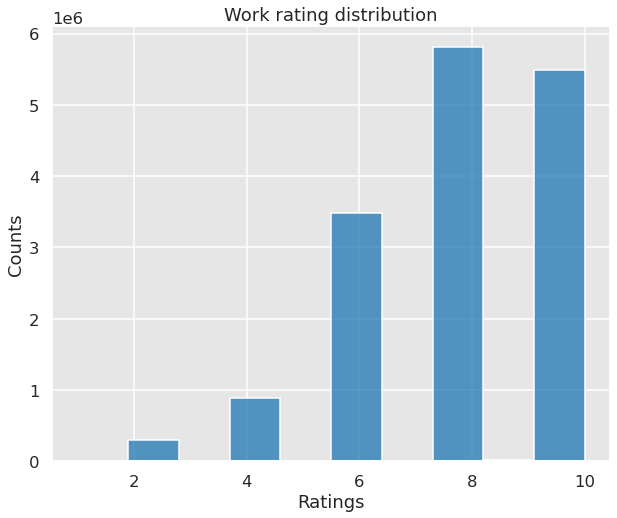

In [79]:
# Show the distribution of ratings per works
_, ax = plt.subplots(figsize=(10, 8))
sns.histplot(work_ratings['rating'], ax=ax, bins=10)
ax.set_ylabel('Counts')
ax.set_xlabel('Ratings')
ax.set_title('Work rating distribution');

In [80]:
by_work = work_ratings[['work_id', 'rating']]\
    .groupby('work_id', observed=True)
by_work_count = by_work[['rating']].count()

In [81]:
work_rated_count = len(by_work_count)
work_5times_rated_count = (by_work_count['rating'] >= 5).sum()

print(f'Number of works which have ratings: {work_rated_count} '
      f'that is {work_rated_count * 100 / len(works):.4f}%')
print(f'Number of works which have at least 5 ratings: '
      f'{work_5times_rated_count} that is '
      f'{work_5times_rated_count * 100 / len(works):.4f}%')

Number of works which have ratings: 53192 that is 100.0000%
Number of works which have at least 5 ratings: 42841 that is 80.5403%


Let's calculate weighted ratings of books. To use usual rating is not the best idea, because a book with a rating of 9 from 10 voters will be considered "better" than a book with a rating of 8.9 from 10,000 voters. Thus, it is better to use "weighted rating". See more details [in the Datacamp article](https://www.datacamp.com/community/tutorials/recommender-systems-python).

In [82]:
# Calculate weighted rating
min_work_rate_count = by_work_count['rating'].quantile(0.99)
mean_work_rate = work_ratings['rating'].mean()
work_ids = by_work_count[by_work_count['rating'] >= min_work_rate_count].index
by_work_weighted = work_ratings\
    .loc[work_ratings['work_id'].isin(work_ids), ['work_id', 'rating']]\
    .groupby('work_id', observed=True).apply(get_weighted_rating,
                                             min_rate_count=min_work_rate_count,
                                             mean_rate=mean_work_rate)\
    .to_frame(name='weighted_rating')

In [83]:
# Get work info
works_data = pd.merge(works[['front_isbn']], books[['title']],
                      left_on='front_isbn', right_index=True)

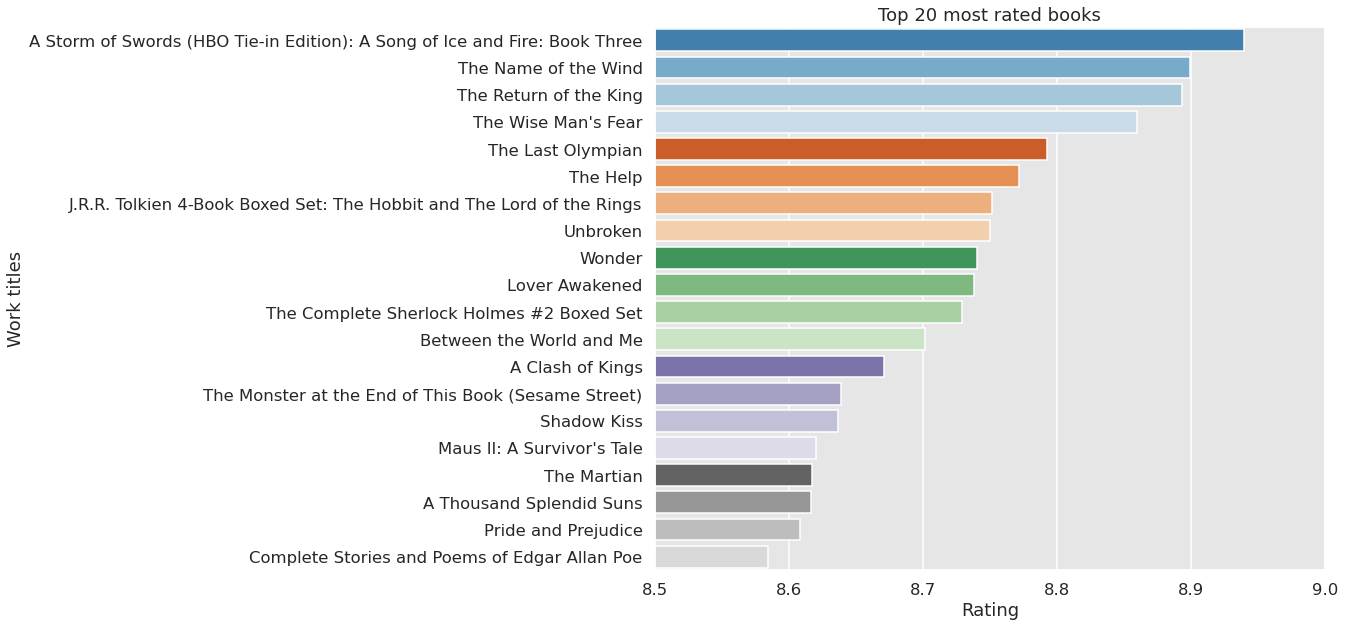

In [84]:
_, ax = plt.subplots(figsize=(12, 10))

# Most rated books
high_rated_works_top = by_work_weighted\
    .sort_values(by='weighted_rating', ascending=False).head(20)
high_rated_works_top = pd.merge(high_rated_works_top,
                                works_data[['title']], how='left',
                                right_index=True, left_index=True)
sns.barplot(x=high_rated_works_top['weighted_rating'],
            y=high_rated_works_top['title'],
            palette=sns_palette, ax=ax, ci=None)
ax.set_xlim(8.5, 9)
ax.set_ylabel('Work titles')
ax.set_xlabel('Rating')
ax.set_title('Top 20 most rated books')
plt.show()

## Save

In [85]:
books.to_csv(os.path.join('data_prep', 'books.csv'), index=True)
categories.to_csv(os.path.join('data_prep', 'categories.csv'), index=True)
roles.to_csv(os.path.join('data_prep', 'contributor_roles.csv'), index=True)
publishers.to_csv(os.path.join('data_prep', 'publishers.csv'), index=True)
series.to_csv(os.path.join('data_prep', 'series.csv'), index=True)
authors.to_csv(os.path.join('data_prep', 'contributors.csv'), index=True)
works.to_csv(os.path.join('data_prep', 'works.csv'), index=True)
book_cats.to_csv(os.path.join('data_prep', 'book_categories.csv'))
book_authors.to_csv(os.path.join('data_prep', 'book_contributors.csv'))
work_ratings.to_csv(os.path.join('data_prep', 'work_ratings.csv'))